In [13]:
from IPython.display import YouTubeVideo

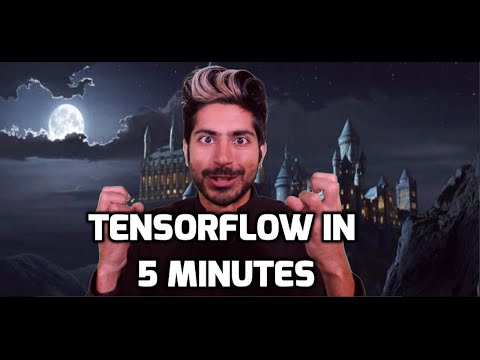

In [16]:
YouTubeVideo("2FmcHiLCwTU")

In [1]:
import tensorflow as tf

In [1]:
import input_data

In [2]:
mnist = input_data.read_data_sets("/home/ali/workspace/tensorFlow_Video_Tutorials/mnist",one_hot=True)

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting /home/ali/workspace/tensorFlow_Video_Tutorials/mnist/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting /home/ali/workspace/tensorFlow_Video_Tutorials/mnist/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting /home/ali/workspace/tensorFlow_Video_Tutorials/mnist/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting /home/ali/workspace/tensorFlow_Video_Tutorials/mnist/t10k-labels-idx1-ubyte.gz


In [8]:
learnin_rate = 0.01
training_iteration = 30
batch_size = 100
display_step = 2

## TF graph input
We must define two place holders, one for the data and one for the labels. The size(shape) of these place holders depends on our data.

Here because our images have 784 pixels then our data place holder shape is 784 and our labels are binary and their shape is 10.

In [9]:
x = tf.placeholder("float", [None, 784]) # 28*28=784
y = tf.placeholder("float", [None, 10]) # 0-9 digits -> 10 classes

## Set Model Weights
Here we set the weights and bias for our model.

We have a 10 neuron layer then we just define a 784*10 weight zero matrix for our weights and 10 for our biases.


In [10]:
W = tf.Variable(tf.zeros([784,10]))
b = tf.Variable(tf.zeros([10]))

In [1]:
import tensorflow as tf

In [8]:
x = tf.constant([[1,2,3],[4,5,6]])
y = tf.constant([[5,2],[8,9],[2,1]])

c = tf.matmul(x,y)
sess = tf.Session()
# sess.as_default()
print (c.eval(session=sess))

[[27 23]
 [72 59]]


In [5]:
c.eval()

ValueError: Cannot evaluate tensor using `eval()`: No default session is registered. Use `with sess.as_default()` or pass an explicit session to `eval(session=sess)`

In [ ]:
# Copyright 2015 The TensorFlow Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the 'License');
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an 'AS IS' BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================
"""A simple MNIST classifier which displays summaries in TensorBoard.
This is an unimpressive MNIST model, but it is a good example of using
tf.name_scope to make a graph legible in the TensorBoard graph explorer, and of
naming summary tags so that they are grouped meaningfully in TensorBoard.
It demonstrates the functionality of every TensorBoard dashboard.
"""
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import argparse
import os
import sys

import tensorflow as tf

from tensorflow.examples.tutorials.mnist import input_data

FLAGS = None


def train():
  # Import data
  mnist = input_data.read_data_sets(FLAGS.data_dir,
                                    one_hot=True,
                                    fake_data=FLAGS.fake_data)

  sess = tf.InteractiveSession()
  # Create a multilayer model.

  # Input placeholders
  with tf.name_scope('input'):
    x = tf.placeholder(tf.float32, [None, 784], name='x-input')
    y_ = tf.placeholder(tf.float32, [None, 10], name='y-input')

  with tf.name_scope('input_reshape'):
    image_shaped_input = tf.reshape(x, [-1, 28, 28, 1])
    tf.summary.image('input', image_shaped_input, 10)

  # We can't initialize these variables to 0 - the network will get stuck.
  def weight_variable(shape):
    """Create a weight variable with appropriate initialization."""
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

  def bias_variable(shape):
    """Create a bias variable with appropriate initialization."""
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

  def variable_summaries(var):
    """Attach a lot of summaries to a Tensor (for TensorBoard visualization)."""
    with tf.name_scope('summaries'):
      mean = tf.reduce_mean(var)
      tf.summary.scalar('mean', mean)
      with tf.name_scope('stddev'):
        stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
      tf.summary.scalar('stddev', stddev)
      tf.summary.scalar('max', tf.reduce_max(var))
      tf.summary.scalar('min', tf.reduce_min(var))
      tf.summary.histogram('histogram', var)

  def nn_layer(input_tensor, input_dim, output_dim, layer_name, act=tf.nn.relu):
    """Reusable code for making a simple neural net layer.
    It does a matrix multiply, bias add, and then uses ReLU to nonlinearize.
    It also sets up name scoping so that the resultant graph is easy to read,
    and adds a number of summary ops.
    """
    # Adding a name scope ensures logical grouping of the layers in the graph.
    with tf.name_scope(layer_name):
      # This Variable will hold the state of the weights for the layer
      with tf.name_scope('weights'):
        weights = weight_variable([input_dim, output_dim])
        variable_summaries(weights)
      with tf.name_scope('biases'):
        biases = bias_variable([output_dim])
        variable_summaries(biases)
      with tf.name_scope('Wx_plus_b'):
        preactivate = tf.matmul(input_tensor, weights) + biases
        tf.summary.histogram('pre_activations', preactivate)
      activations = act(preactivate, name='activation')
      tf.summary.histogram('activations', activations)
      return activations

  hidden1 = nn_layer(x, 784, 500, 'layer1')

  with tf.name_scope('dropout'):
    keep_prob = tf.placeholder(tf.float32)
    tf.summary.scalar('dropout_keep_probability', keep_prob)
    dropped = tf.nn.dropout(hidden1, keep_prob)

  # Do not apply softmax activation yet, see below.
  y = nn_layer(dropped, 500, 10, 'layer2', act=tf.identity)

  with tf.name_scope('cross_entropy'):
    # The raw formulation of cross-entropy,
    #
    # tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(tf.softmax(y)),
    #                               reduction_indices=[1]))
    #
    # can be numerically unstable.
    #
    # So here we use tf.nn.softmax_cross_entropy_with_logits on the
    # raw outputs of the nn_layer above, and then average across
    # the batch.
    diff = tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y)
    with tf.name_scope('total'):
      cross_entropy = tf.reduce_mean(diff)
  tf.summary.scalar('cross_entropy', cross_entropy)

  with tf.name_scope('train'):
    train_step = tf.train.AdamOptimizer(FLAGS.learning_rate).minimize(
        cross_entropy)

  with tf.name_scope('accuracy'):
    with tf.name_scope('correct_prediction'):
      correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
    with tf.name_scope('accuracy'):
      accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
  tf.summary.scalar('accuracy', accuracy)

  # Merge all the summaries and write them out to
  # /tmp/tensorflow/mnist/logs/mnist_with_summaries (by default)
  merged = tf.summary.merge_all()
  train_writer = tf.summary.FileWriter(FLAGS.log_dir + '/train', sess.graph)
  test_writer = tf.summary.FileWriter(FLAGS.log_dir + '/test')
  tf.global_variables_initializer().run()

  # Train the model, and also write summaries.
  # Every 10th step, measure test-set accuracy, and write test summaries
  # All other steps, run train_step on training data, & add training summaries

  def feed_dict(train):
    """Make a TensorFlow feed_dict: maps data onto Tensor placeholders."""
    if train or FLAGS.fake_data:
      xs, ys = mnist.train.next_batch(100, fake_data=FLAGS.fake_data)
      k = FLAGS.dropout
    else:
      xs, ys = mnist.test.images, mnist.test.labels
      k = 1.0
    return {x: xs, y_: ys, keep_prob: k}

  for i in range(FLAGS.max_steps):
    if i % 10 == 0:  # Record summaries and test-set accuracy
      summary, acc = sess.run([merged, accuracy], feed_dict=feed_dict(False))
      test_writer.add_summary(summary, i)
      print('Accuracy at step %s: %s' % (i, acc))
    else:  # Record train set summaries, and train
      if i % 100 == 99:  # Record execution stats
        run_options = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE)
        run_metadata = tf.RunMetadata()
        summary, _ = sess.run([merged, train_step],
                              feed_dict=feed_dict(True),
                              options=run_options,
                              run_metadata=run_metadata)
        train_writer.add_run_metadata(run_metadata, 'step%03d' % i)
        train_writer.add_summary(summary, i)
        print('Adding run metadata for', i)
      else:  # Record a summary
        summary, _ = sess.run([merged, train_step], feed_dict=feed_dict(True))
        train_writer.add_summary(summary, i)
  train_writer.close()
  test_writer.close()


def main(_):
  if tf.gfile.Exists(FLAGS.log_dir):
    tf.gfile.DeleteRecursively(FLAGS.log_dir)
  tf.gfile.MakeDirs(FLAGS.log_dir)
  train()


if __name__ == '__main__':
  parser = argparse.ArgumentParser()
  parser.add_argument('--fake_data', nargs='?', const=True, type=bool,
                      default=False,
                      help='If true, uses fake data for unit testing.')
  parser.add_argument('--max_steps', type=int, default=1000,
                      help='Number of steps to run trainer.')
  parser.add_argument('--learning_rate', type=float, default=0.001,
                      help='Initial learning rate')
  parser.add_argument('--dropout', type=float, default=0.9,
                      help='Keep probability for training dropout.')
  parser.add_argument(
      '--data_dir',
      type=str,
      default=os.path.join(os.getenv('TEST_TMPDIR', '/tmp'),
                           'tensorflow/mnist/input_data'),
      help='Directory for storing input data')
  parser.add_argument(
      '--log_dir',
      type=str,
      default=os.path.join(os.getenv('TEST_TMPDIR', '/tmp'),
                           'tensorflow/mnist/logs/mnist_with_summaries'),
      help='Summaries log directory')
  FLAGS, unparsed = parser.parse_known_args()
  tf.app.run(main=main, argv=[sys.argv[0]] + unparsed)

Extracting /tmp/tensorflow/mnist/input_data/train-images-idx3-ubyte.gz
Extracting /tmp/tensorflow/mnist/input_data/train-labels-idx1-ubyte.gz
Extracting /tmp/tensorflow/mnist/input_data/t10k-images-idx3-ubyte.gz
Extracting /tmp/tensorflow/mnist/input_data/t10k-labels-idx1-ubyte.gz
Accuracy at step 0: 0.1004
Accuracy at step 10: 0.7402
Accuracy at step 20: 0.8439
Accuracy at step 30: 0.8719
Accuracy at step 40: 0.8853
Accuracy at step 50: 0.8954
Accuracy at step 60: 0.9026
Accuracy at step 70: 0.9076
Accuracy at step 80: 0.9106
